In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd

In [2]:
individual_details = pd.read_csv('New_Data/IndividualDetails.csv')
india_covid_19 = pd.read_csv('New_Data/covid_19_india.csv')

In [15]:
individual_details.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   544 non-null    int64  
 1   Unique id            544 non-null    int64  
 2   Government id        130 non-null    object 
 3   Diagnosed date       544 non-null    object 
 4   Age                  266 non-null    float64
 5   Gender               544 non-null    object 
 6   Detected city        400 non-null    object 
 7   Detected city pt     544 non-null    object 
 8   Detected district    387 non-null    object 
 9   Detected state       544 non-null    object 
 10  Nationality          358 non-null    object 
 11  Current status       543 non-null    object 
 12  Status change date   544 non-null    object 
 13  Notes                541 non-null    object 
 14  Current location     15 non-null     object 
 15  Current location pt  544 non-null    obj


The aim of this analysis is to understand various statistics related to the age group of the infected by Covid 19 in India.

In [9]:
age_cleaned = individual_details[["Age", "Detected state"]]
age_cleaned = age_cleaned[pd.to_numeric(age_cleaned["Age"], errors='coerce').notnull()]
age_cleaned = age_cleaned.astype({'Age': 'int'})

In [12]:
sum(age_cleaned["Age"] > 20) / age_cleaned.count()

Age               0.921053
Detected state    0.921053
dtype: float64

This can either be attributed to young population in India or the mutations in virus that are making it more resiliant allowing it to infect younger people.

Virus adapting to local conditions will have a few indicators in terms of decrease in average age with time and and places with high spread (Both these factors indicate more communal spread). This analysis would give more accurate results if community spread data is available. In case of India, this hasen't been properly documented after the forst 500 - 100 cases. So we resort to these methods to get an estimate.


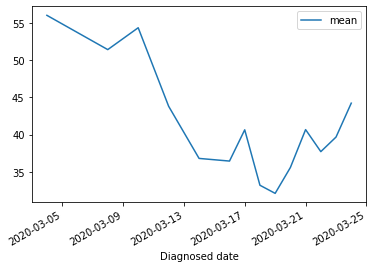

In [30]:
age_cleaned = individual_details[["Age", "Diagnosed date"]]
age_cleaned = age_cleaned[pd.to_numeric(age_cleaned["Age"], errors='coerce').notnull()]
age_cleaned = age_cleaned.astype({'Age': 'int'})

age_cleaned = age_cleaned.groupby(["Diagnosed date"]).agg(["mean", "count"])["Age"]
age_cleaned.index = pd.to_datetime(age_cleaned.index,dayfirst=True)
age_cleaned = age_cleaned.sort_index()
age_cleaned[age_cleaned["count"] >= 5].plot(y = "mean")

In [24]:
age_cleaned = individual_details[["Age", "Detected state"]]
age_cleaned = age_cleaned[pd.to_numeric(age_cleaned["Age"], errors='coerce').notnull()]
age_cleaned = age_cleaned.astype({'Age': 'int'})
age_cleaned = age_cleaned.groupby(["Detected state"]).agg(["mean", "count"])["Age"]
counts = individual_details[["Detected state", "ID"]].groupby(["Detected state"]).agg(["count"])["ID"]
counts.columns = ["all_counts"]

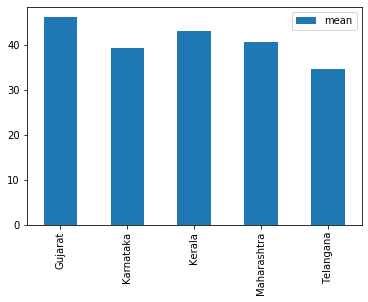

In [25]:
state_age = pd.concat([counts, age_cleaned], axis = 1,sort = True).sort_values(by = ["all_counts"])

state_age["States/UT"] = state_age.index

state_age["States/UT"].replace("Telangana", "Telengana", inplace = True)
state_age["States/UT"].replace("Dadra and Nagar Haveli", "Dadara and Nagar Havelli", inplace = True)
state_age.sort_values(by=['States/UT'],inplace = True)


ax = state_age[state_age["count"] > 20].plot(kind = "bar", y = "mean")

In [26]:


map_data = gpd.read_file("./India_Shape_File/Indian_States.shp")
map_data.rename(columns = {"st_nm":"States/UT"}, inplace = True)

map_data["States/UT"] = map_data["States/UT"].str.replace("&","and")
map_data["States/UT"].replace("Arunanchal Pradesh", "Arunachal Pradesh", inplace = True)
map_data["States/UT"].replace("Telangana", "Telengana", inplace = True)
map_data["States/UT"].replace("NCT of Delhi",  "Delhi", inplace = True)
map_data['States/UT'].replace('Andaman and Nicobar Island', 'Andaman and Nicobar Islands',inplace = True)

map_data.head()



,States/UT,geometry
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Arunachal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
3,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."


In [27]:
state_details = pd.pivot_table(india_covid_19, values=['ConfirmedForeignNational','ConfirmedIndianNational','Confirmed','Deaths','Cured'], index='State/UnionTerritory', aggfunc='max')
state_details = state_details.sort_values(by='Confirmed', ascending= False)

state_details["Total"] = state_details.Confirmed + state_details.Cured + state_details.Deaths

state_details["States/UT"] = state_details.index
state_details.sort_values(by=['States/UT'],inplace =True)
# state_details[state_details['States/UT']=='Telengana'].head()

In [28]:
merged_data = pd.merge(map_data, state_age, how = "left", on = "States/UT")
merged_data.fillna(0, inplace = True)
merged_data = pd.merge(merged_data, state_details, how = "left", on = "States/UT")
merged_data.fillna(0, inplace = True)

merged_data['coords'] = merged_data['geometry'].apply(lambda x: x.representative_point().coords[:])
merged_data['coords'] = [coords[0] for coords in merged_data['coords']]

NotImplementedError: fillna currently only supports filling with a scalar geometry

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis("off")

ax.set_title('Covid-19 Statewise Data — Mean Age', 
             fontdict =  {"fontsize": "25", "fontweight" : "3"})

merged_data.plot(column = "Total", cmap="YlOrRd", 
                 linewidth=0.8, ax=ax, edgecolor="0", 
                 legend = True)
# plt.show()


# merged_data.plot()
for idx, row in merged_data.iterrows():
    plt.annotate(s=round(row['mean'],1), xy=row['coords'],
                 horizontalalignment='center')



Above plot shows the distribution of average age in various geographical locations. Since age is nor properly documented in data provided by a few states, only the states for which proper data is available are considered.

From the plot, it can be seen that in most of the cases, the average age is around 45. There are two factors that can influence the average age of Covid victims in a state. First one is the average age for population of the state itself and the other one being high communal spread leading to lower age groups being affected. The plot correlates with the average population age of the states( Tamilnadu, Uttarpradesh have higher average while Maharastra has lower average for the average age of population in respective states.
Conclusions

    Even though Covid is known to affect people of older age group, in a community with an younger population, it can be seen that younger people are getting affected too. Whether a younger population means less rate of spread is a point of discussion*.
    There is no conclusive evidence to prove that the virus is growing resiliant to attack more young people with more communal spread. BUt the evidence weakly points to that happening. Another factor for this might be virus becoming more resiliant to local conditions rather than affecting younger people.
    More conclusions can be drawn combining this with further analysis on other factors.

*Although stats show that the rate of spread is less in India compared to other contries, various other probable reasons like exposure to Hydro Chloroquione(malarial cases in tropical countries), vaccinations for TB etc have been cited for this. So a younger community may not be the only explanation.
